Клонирование репозитория с необходимыми функциями и моделью, а также устаовка зависимостей

In [ ]:
!git clone https://github.com/lukan992/anomaly_detect_hackathon.git
!pip install orion-ml
!pip install tensorflow[and-cuda]==2.14.1

fatal: целевой путь «anomaly_detect_hackathon» уже существует и не является пустым каталогом.


zsh:1: no matches found: tensorflow[and-cuda]==2.14.1


Импорт библиотек

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime
#импорт модели
from anomaly_detect_hackathon.model import hyperparameters
from orion.primitives.tadgan import TadGAN

from orion.primitives.tadgan import score_anomalies

from anomaly_detect_hackathon.utils import plot, plot_ts, plot_rws, plot_error, unroll_ts

Загрузка даных с датчика и запись названия всех датчиков в список col_names для возмоности поиска аномалий со всех датчиков единоразово

In [11]:
project_data = pd.read_csv('results.csv')
col_names = []
for col_name in project_data.columns[1:-1]:
    col_names.append(col_name)

Преобразование датафрейма в вид со значениями датчика и временем снятия данных с датчика

In [12]:
sensor_name = col_names[1]
project_data[sensor_name] = pd.to_numeric(project_data[sensor_name], errors='coerce')
project_data = project_data[["timestamp", sensor_name]]
project_data.head()

,timestamp,AB_1
0,2023-01-30 10:09:00,224.988092
1,2023-01-30 10:10:00,187.743678
2,2023-01-30 10:11:00,212.649352
3,2023-01-30 10:12:00,195.079863
4,2023-01-30 10:13:00,233.727964


Преобразование столбца с временем в столец с секундами, прошедшими от съёма первых данных

In [13]:
# Две строки с датами
date1_str = project_data['timestamp'][0]
for i in range(project_data.shape[0]):
    date2_str = project_data['timestamp'].iloc[i]

    # Преобразование строк в datetime объекты
    date1 = datetime.strptime(date1_str, "%Y-%m-%d %H:%M:%S")
    date2 = datetime.strptime(date2_str, "%Y-%m-%d %H:%M:%S")

    # Перевод в UNIX-время (в секундах с 1 января 1970 года)
    timestamp1 = int(date1.timestamp())
    timestamp2 = int(date2.timestamp())

    # Разница во времени в секундах
    difference_in_seconds = timestamp2 - timestamp1
    project_data['timestamp'][i] = difference_in_seconds

# Вывод результата
print(f"Timestamp 1: {timestamp1} секунд {date1_str}")
print(f"Timestamp 2: {timestamp2} секунд{date2_str}")
print(f"Разница: {difference_in_seconds} секунд")


/tmp/ipykernel_823005/3013914119.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  project_data['timestamp'][i] = difference_in_seconds


Timestamp 1: 1675062540 секунд 2023-01-30 10:09:00
Timestamp 2: 1686826200 секунд2023-06-15 13:50:00
Разница: 11763660 секунд


Получение двух массивов с данными и временем для дальнейшей обработки и создание датафрейма из этих данных

In [14]:
a = project_data['timestamp'].tolist()
b = project_data[sensor_name].tolist()

data = {'timestamp': a, 'value': b}
df = pd.DataFrame(data)

Функция агрегирует значения за заданный промежуток времени, то есть собирает в массив данные с промежутком во времени равным переданному значению

In [15]:
def time_segments_aggregate(X, interval, time_column, method=['mean']):
    """Aggregate values over given time span.
    Args:
        X (ndarray or pandas.DataFrame):
            N-dimensional sequence of values.
        interval (int):
            Integer denoting time span to compute aggregation of.
        time_column (int):
            Column of X that contains time values.
        method (str or list):
            Optional. String describing aggregation method or list of strings describing multiple
            aggregation methods. If not given, `mean` is used.
    Returns:
        ndarray, ndarray:
            * Sequence of aggregated values, one column for each aggregation method.
            * Sequence of index values (first index of each aggregated segment).
    """
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    X = X.sort_values(time_column).set_index(time_column)

    if isinstance(method, str):
        method = [method]

    start_ts = X.index.values[0]
    max_ts = X.index.values[-1]

    values = list()
    index = list()
    while start_ts <= max_ts:
        end_ts = start_ts + interval
        subset = X.loc[start_ts:end_ts - 1]
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method
        ]
        values.append(np.concatenate(aggregated))
        index.append(start_ts)
        start_ts = end_ts

    return np.asarray(values), np.asarray(index)

X, index = time_segments_aggregate(df, interval=60, time_column='timestamp')


Заполняем пропуски данных и масштабируем (нормализируем) данные для последующей обработки

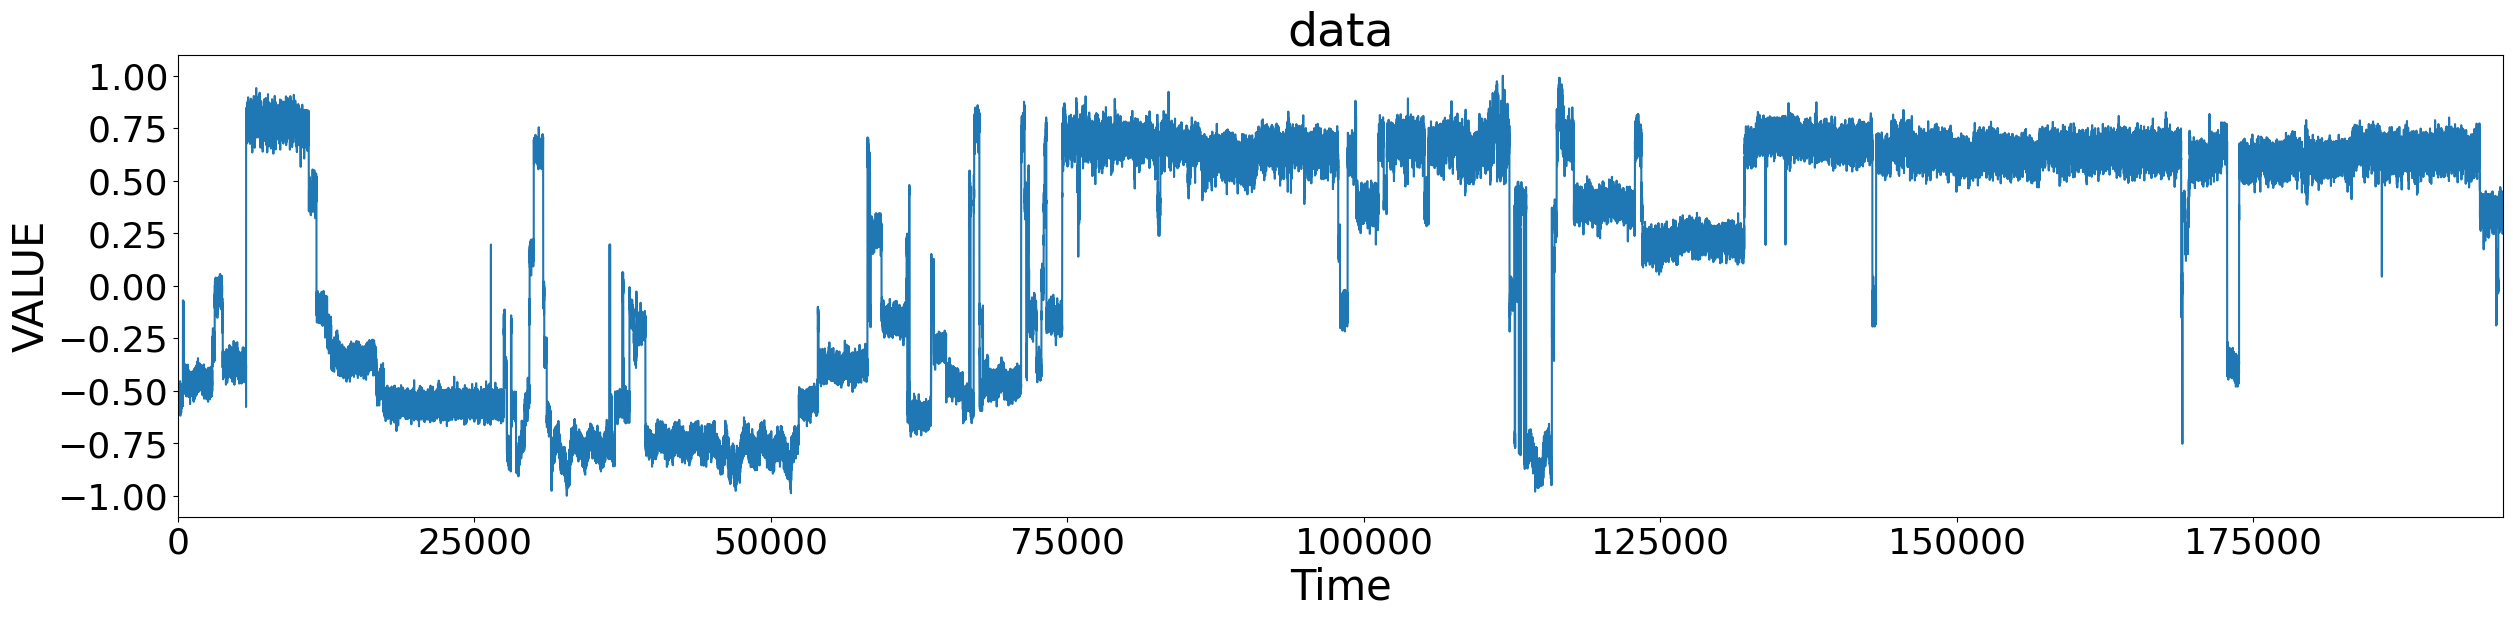

In [16]:
imp = SimpleImputer()
X = imp.fit_transform(X)
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
plot_ts(X)



Применение скользящего окна на наши данные

In [17]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    """Create rolling window sequences out of time series data.
    The function creates an array of input sequences and an array of target sequences by rolling
    over the input sequence with a specified window.
    Optionally, certain values can be dropped from the sequences.
    Args:
        X (ndarray):
            N-dimensional sequence to iterate over.
        index (ndarray):
            Array containing the index values of X.
        window_size (int):
            Length of the input sequences.
        target_size (int):
            Length of the target sequences.
        step_size (int):
            Indicating the number of steps to move the window forward each round.
        target_column (int):
            Indicating which column of X is the target.
        drop (ndarray or None or str or float or bool):
            Optional. Array of boolean values indicating which values of X are invalid, or value
            indicating which value should be dropped. If not given, `None` is used.
        drop_windows (bool):
            Optional. Indicates whether the dropping functionality should be enabled. If not
            given, `False` is used.
    Returns:
        ndarray, ndarray, ndarray, ndarray:
            * input sequences.
            * target sequences.
            * first index value of each input sequence.
            * first index value of each target sequence.
    """
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)

X, y, X_index, y_index = rolling_window_sequences(X, index, 
                                                  window_size=100, 
                                                  target_size=1, 
                                                  step_size=1,
                                                  target_column=0)


Вывод размерности данных и самих окон для наглядности

Training data input shape: (195962, 100, 1)
Training data index shape: (195962,)
Training y shape: (195962, 1)
Training y index shape: (195962,)


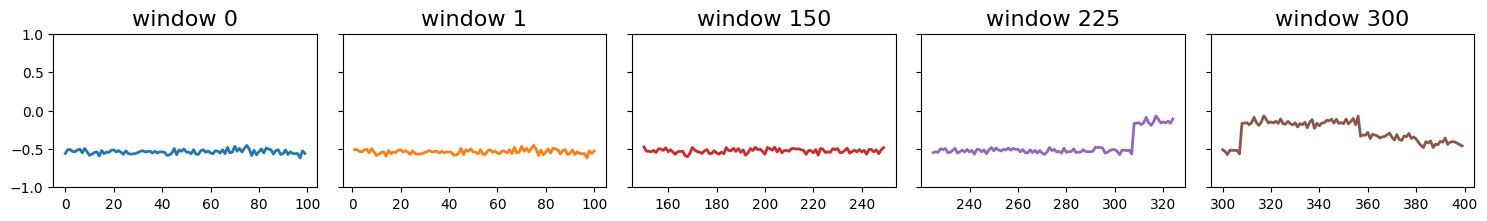

In [18]:
print("Training data input shape: {}".format(X.shape))
print("Training data index shape: {}".format(X_index.shape))
print("Training y shape: {}".format(y.shape))
print("Training y index shape: {}".format(y_index.shape))
plot_rws(X)


Обучение модели TadGAN и установка гипепарамеров

In [19]:
hyperparameters["epochs"] = 3
hyperparameters["input_shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "tensorflow.keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64

tgan = TadGAN(**hyperparameters)
tgan.fit(X)

2024-12-13 13:09:45.672807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-13 13:09:45.677439: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-13 13:09:45.679225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2024-12-13 13:09:58.005306: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7b00b0018490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-13 13:09:58.005334: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-12-13 13:09:58.009102: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-13 13:09:58.011330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-12-13 13:09:58.076098: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-12-13 13:09:58.446940: W tensorflow/core/kernels/conv_ops_gpu.cc:322] None of the algorithms provided by cuDNN frontend heuristics worked; trying fallback algorithms. 

Epoch: 1/3, Losses: {'cx_loss': -0.8111, 'cz_loss': -3.7946, 'eg_loss': 5.1693}
Epoch: 2/3, Losses: {'cx_loss': -0.4041, 'cz_loss': -4.3581, 'eg_loss': -2.1117}
Epoch: 3/3, Losses: {'cx_loss': -0.367, 'cz_loss': -4.2797, 'eg_loss': 14.9555}


Предсказывание данных и просмотр получившихся окон

6124/6124 [==============================] - 10s 2ms/step


2024-12-13 13:36:33.692986: W tensorflow/core/kernels/conv_ops_gpu.cc:322] None of the algorithms provided by cuDNN frontend heuristics worked; trying fallback algorithms.  Conv: batch: 26
in_depths: 64
out_depths: 64
in: 1
in: 92
data_format: 1
filter: 1
filter: 5
filter: 64
dilation: 1
dilation: 1
stride: 1
stride: 1
padding: 0
padding: 0
dtype: DT_DOUBLE
group_count: 1
device_identifier: "sm_8.6 with 8225030144B RAM, 38 cores, 1785000KHz clock, 7001000KHz mem clock, 3145728B L2$"
version: 3



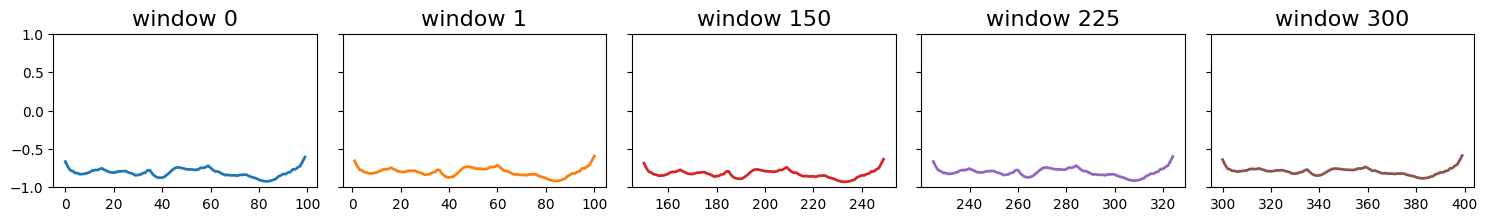

In [20]:
X_hat, critic = tgan.predict(X)

# visualize X_hat
plot_rws(X_hat)


Вывод оригиналиного и сгенерированного графиков

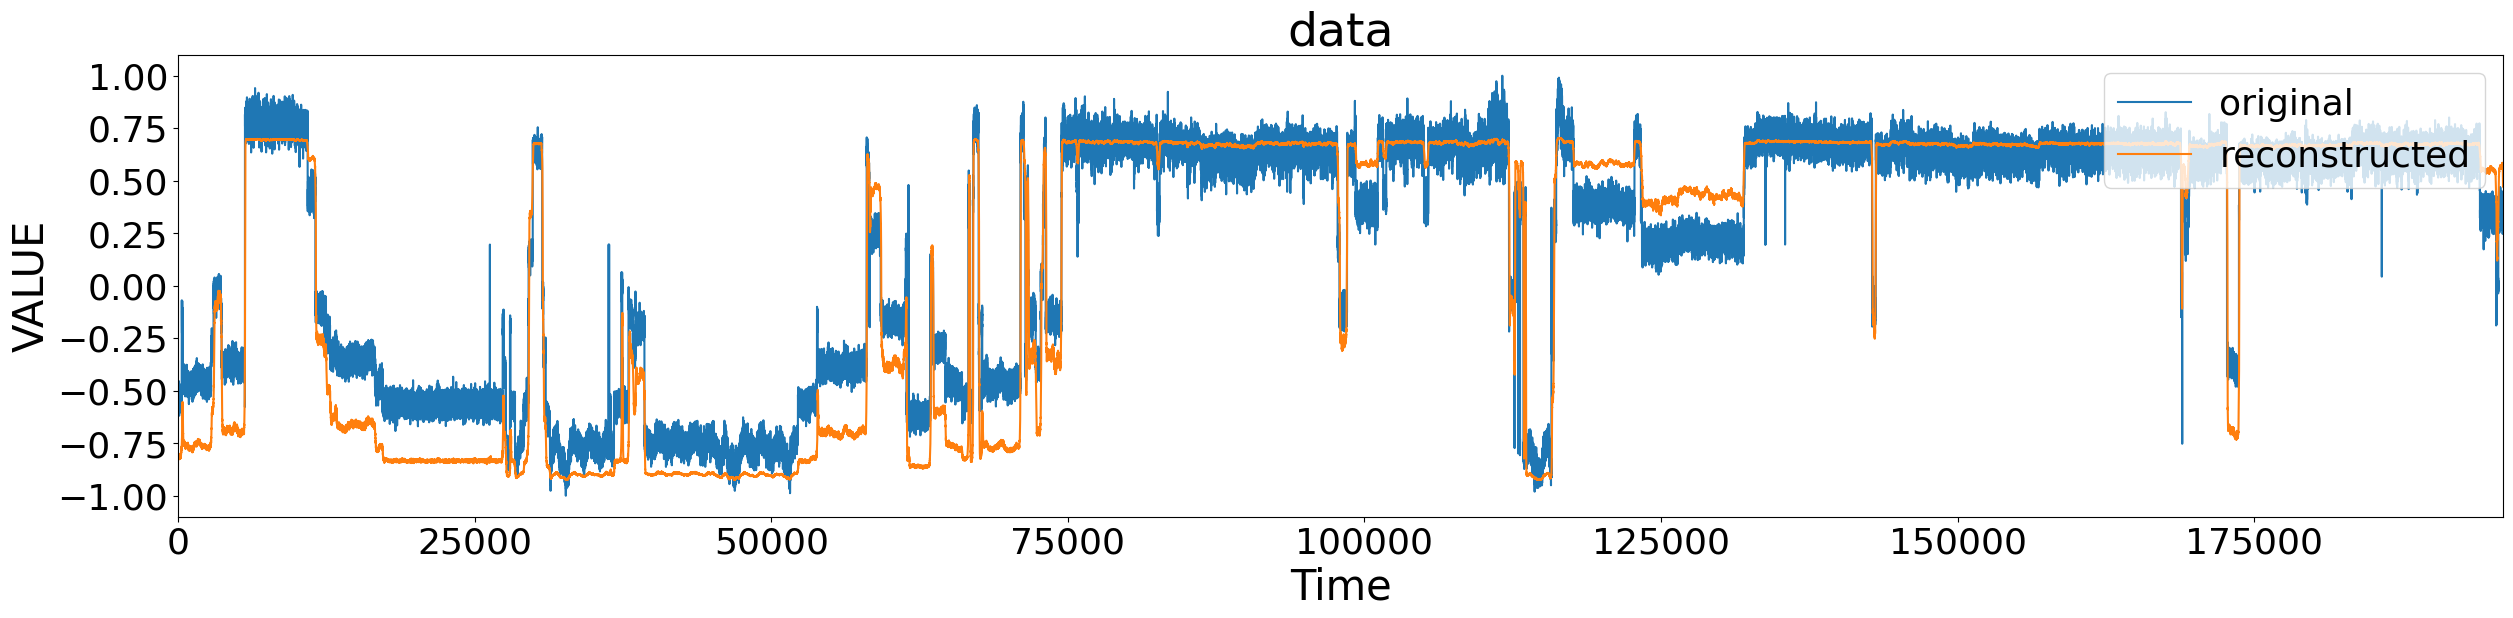

In [21]:
y_hat = unroll_ts(X_hat)

# plot the time series
plot_ts([y, y_hat], labels=['original', 'reconstructed'])


Вычисление ошибки генерации

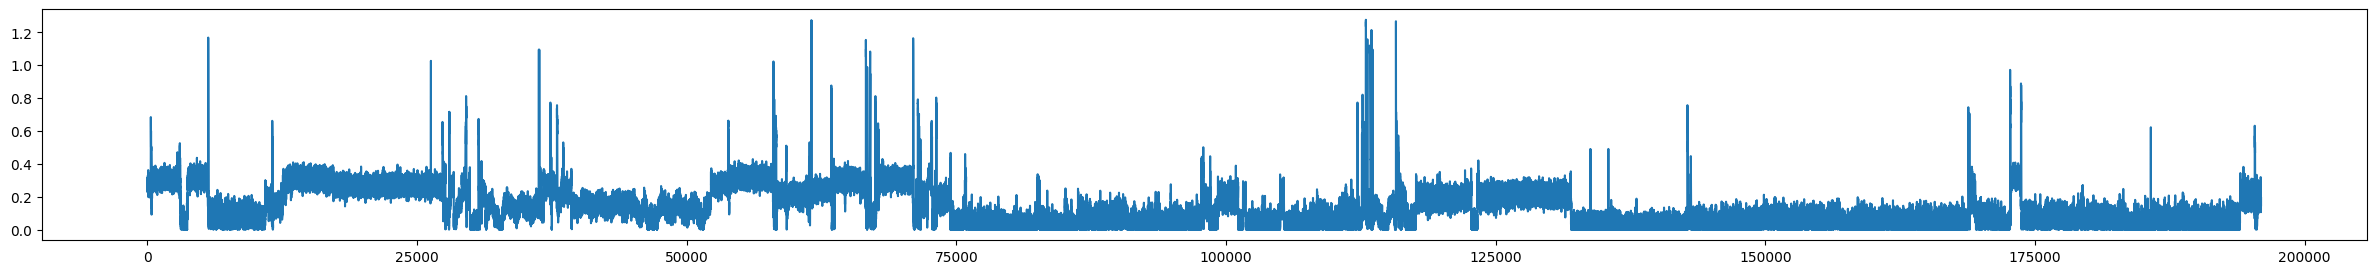

In [22]:
error = np.zeros(shape=y.shape)
length = y.shape[0]
for i in range(length):
    error[i] = abs(y_hat[i] - y[i])

# visualize the error curve
fig = plt.figure(figsize=(30, 3))
plt.plot(error)
plt.show()


Построение графиков: показания с датчика, предсказанные данные датчика поверх снятых с датчика данных, графики вероятности аномалий(на втором графике хорошо видно совокупности аномалий, на третьем графике хорошо видно точечные аномалии)

In [23]:

error_aggregate, true_index, true, pred = score_anomalies(X, X_hat, critic, X_index, rec_error_type="dtw", comb="mult")
error_pinpoints, _, _, _ = score_anomalies(X, X_hat, critic, X_index, rec_error_type="dtw", comb="mult", smooth=False)
pred = np.array(pred).mean(axis=2)


Отображение графиков

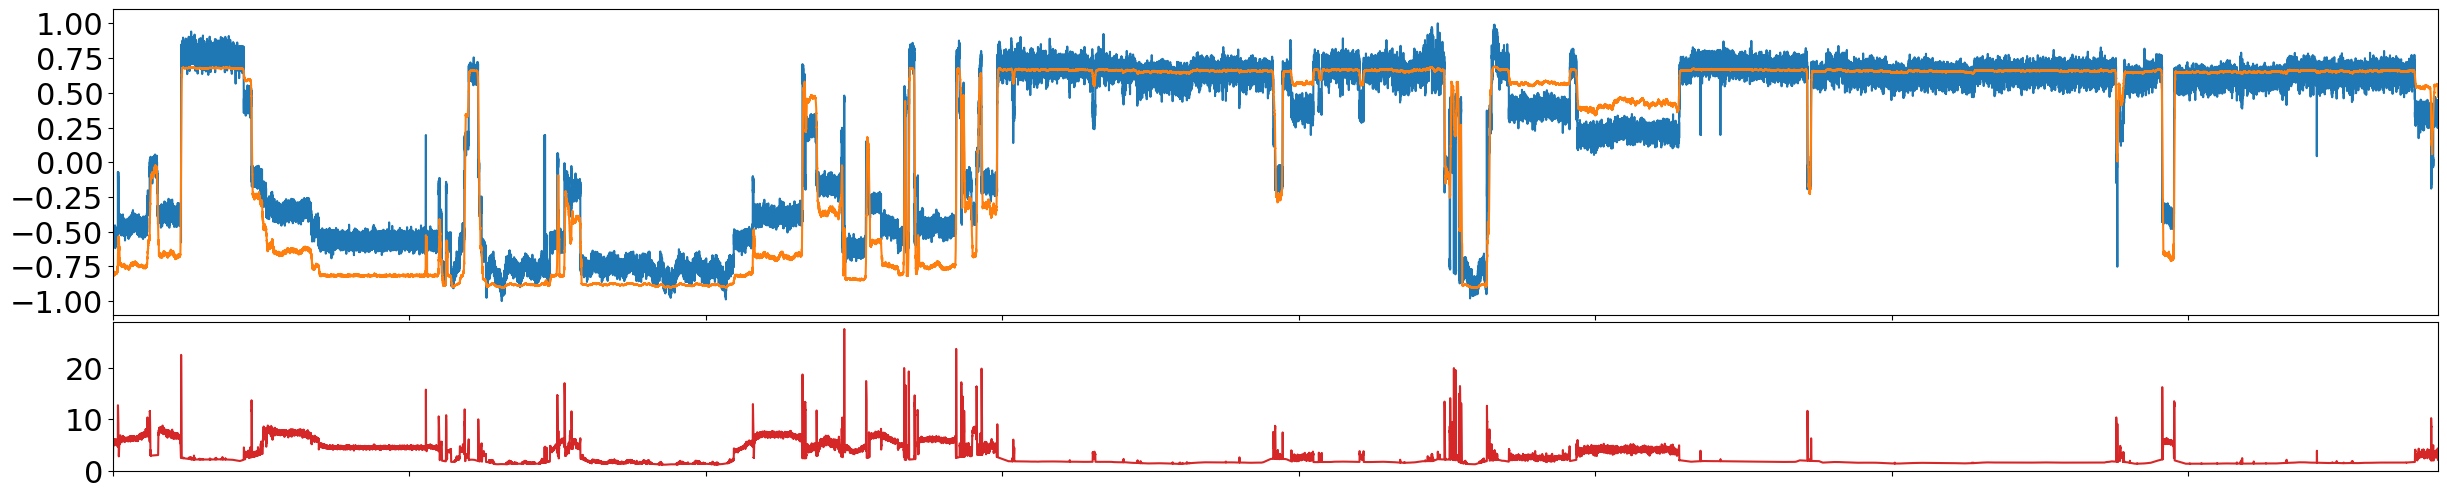

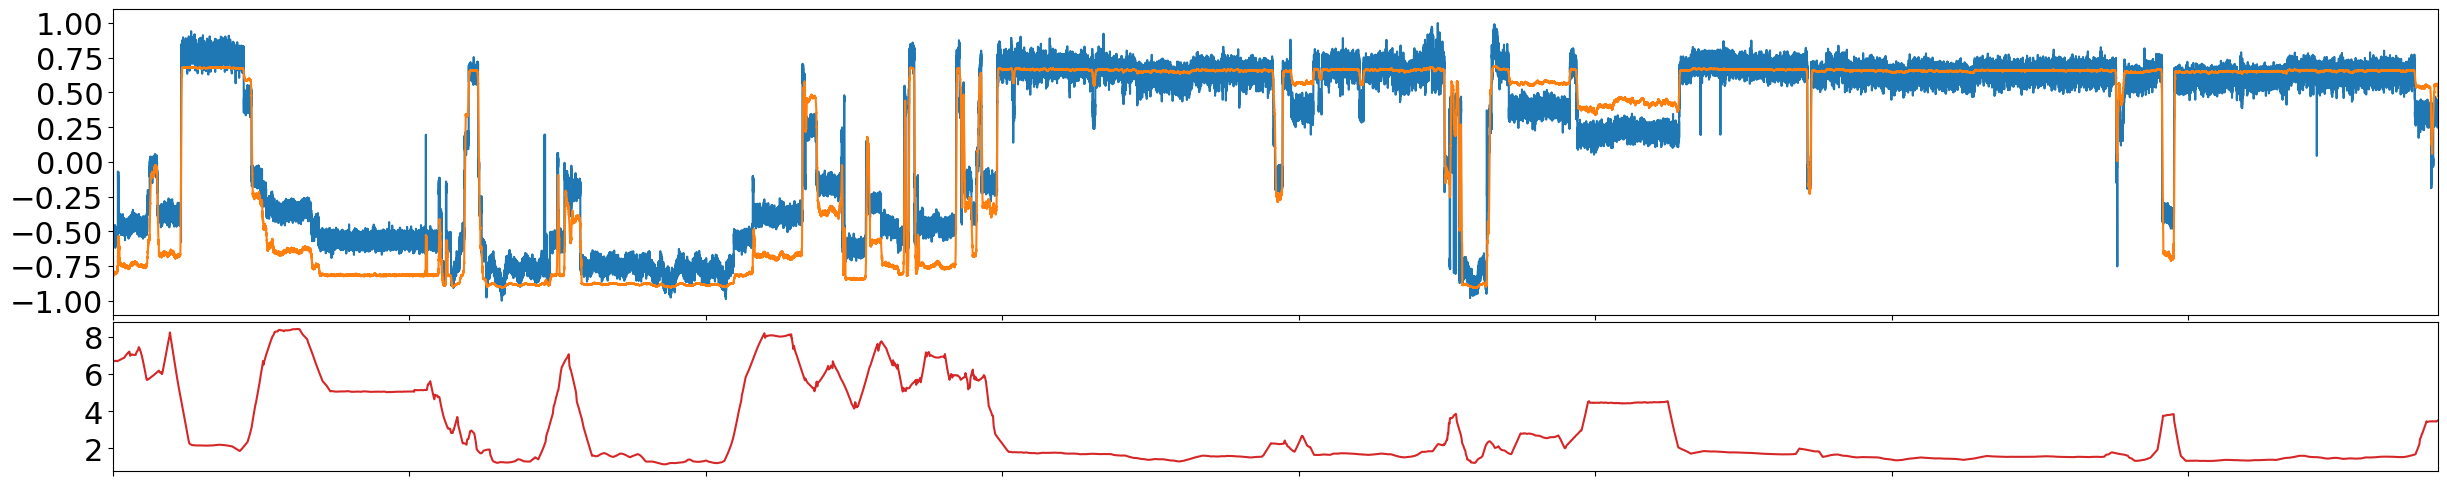

In [24]:
plot_error([[true, pred], error_pinpoints])
plot_error([[true, pred], error_aggregate])